In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler

from nltk.corpus import stopwords
from pymystem3 import Mystem

from MulticoreTSNE import MulticoreTSNE as TSNE
import umap
from sklearn.decomposition import TruncatedSVD, PCA

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set()

In [3]:
SEED = 42

In [4]:
mystem = Mystem()
russian_stopwords = stopwords.words("russian")

In [ ]:
df = pd.read_csv('data.csv')

In [39]:
print(df.shape)
df.head(2)

(1920, 7)


,company_categories,company_features,company_links,company_name,company_url,phone_number,source
0,Спецтехника и спецавтомобили;Услуги грузчиков;...,коммунальная техника,https://vk.com/pr.bratsk,Компания Персональное решение,NaN,73953274827,Yandex API
1,Агентство недвижимости,NaN,NaN,АН Индустриальное,NaN,79028351016,Yandex API


## Data preprocessing

In [40]:
def preprocess_text(series_column):
    ''' Text preprocessing
    
    To lower case, keep digits and letters only, lemmatization, throw out stop words and words with length less 3
    
    Parameters:
        series_column - pandas.series
        
    Return:
        preprocessed series
    '''
    series_column = series_column.str.lower()
    series_column = series_column.replace(r'[^абвгдеёжзийклмнопрстуфхцчшщъыьэюя]', ' ', regex = True)
    
    for i, text in series_column.iteritems():
         #tokens = mystem.lemmatize(text)
        tokens = text.split(' ')
        tokens = [token for token in tokens if token not in [' ', '\n'] 
                                              and token not in russian_stopwords
                                              and len(token) > 2]
        
        text = ' '.join(tokens)
        text = text.replace('o', 'о')
        text = text.replace('ё', 'е')
        series_column[i] = text
    
    return series_column

def hopkins_statistics(X):
    '''Calculate hopkins statistics to check cluster stucture in data
    
    Parameters:
        X - numpy matrix
        
    Return:
        statistics
        
    Note:
        Estimation the clusterability of a dataset. A score between 0 and 1, a score around 0.5 express
        no clusterability and a score tending to 0 express a high cluster tendency
    '''
    n, d = X.shape[0], X.shape[1]
    m = int(0.1 * n) # heuristic from article
    
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
 
    rand_X = sample(range(n), m)
 
    ujd = []
    wjd = []
    for j in range(m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0), np.amax(X,axis=0), d).reshape(1, -1)
                                    , 2, return_distance=True)
        ujd.append(u_dist[0][1])
        
        w_dist, _ = nbrs.kneighbors(X[rand_X[j]].reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(wjd) / (sum(ujd) + sum(wjd))
    
    return H

In [41]:
df['source'].unique()

array(['Yandex API'], dtype=object)

In [42]:
#I's said that it's needed to just cluster without keep attention info about phone's numbers
#so i don't use the fact unique numbers less than all numbers in the dataset
df['phone_number'].unique().shape[0]

1429

In [43]:
df.isna().sum()

company_categories       0
company_features       978
company_links         1123
company_name             0
company_url           1920
phone_number             0
source                   0
dtype: int64

In [44]:
#drop useless
df = df.drop(['source', 'company_url', 'company_links'], axis=1)

In [45]:
#change nan for convenient work
df = df.replace(np.nan, '', regex=True)

In [46]:
df['company_categories'] = preprocess_text(df['company_categories'])
df['company_features'] = preprocess_text(df['company_features'])
df['company_name'] = preprocess_text(df['company_name'])

In [47]:
#concat main text
df['cat_feats'] = df['company_categories'] + ' ' + df['company_features']
df['cat_feats_name'] = df['company_categories'] + ' ' + df['company_features'] + ' ' + df['company_name']

In [48]:
df.head(5)

,company_categories,company_features,company_name,phone_number,cat_feats,cat_feats_name
0,спецтехника спецавтомобили услуги грузчиков пе...,коммунальная техника,компания персональное решение,73953274827,спецтехника спецавтомобили услуги грузчиков пе...,спецтехника спецавтомобили услуги грузчиков пе...
1,агентство недвижимости,,индустриальное,79028351016,агентство недвижимости,агентство недвижимости индустриальное
2,стоматологическая поликлиника стоматологическа...,детская услуги,стоматология жемчужины,79120189455,стоматологическая поликлиника стоматологическа...,стоматологическая поликлиника стоматологическа...
3,аптека,оплата картой,аптека бережливых,78124426652,аптека оплата картой,аптека оплата картой аптека бережливых
4,регистрационная палата министерства ведомства ...,,межрайонный отдел перми управления росреестра ...,73422836588,регистрационная палата министерства ведомства ...,регистрационная палата министерства ведомства ...


In [49]:
#check count unique words in dataset
s = ''
for i, x in df['cat_feats_name'].iteritems():
    s += x + ' '
np.unique(s.split()).shape

(3110,)

In [51]:
'денежные' in s

True

**Encoding**

In [24]:
from gensim.models import Word2Vec

In [86]:
#vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.05, ngram_range=(1, 1))
vectorizer = CountVectorizer(max_df=0.95, min_df=0.05, ngram_range=(1, 2))
matrix = vectorizer.fit_transform(df['cat_feats_name'])
matrix = matrix.toarray()

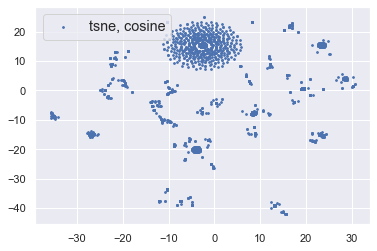

In [87]:
plot_embeddings(matrix.copy(), 'tsne', 'cosine')

**Check clustering structure**

In [88]:
print('Hopkins statisctics scaled matrix:', hopkins_statistics(matrix_sc))
print('Hopkins statisctics:', hopkins_statistics(matrix))

Hopkins statisctics scaled matrix: 0.03156308730394783
Hopkins statisctics: 0.01505973487911372


Seems there're some cluster structure in data, try to visualize it

**Visualization of embeddings of data**

In [54]:
def plot_embeddings(matrix, method='tsne', metric='euclidean', c=None):
    ''' Plot graphics based on embeddings
    
    Parameters:
        matrix - numpy array
        method - 'tsne', 'umap' or 'pca'. Used to print results
        metric - metric is used to create embeddings
    '''
    if method == 'tsne':
        plt.figure()
        embeddings = TSNE(metric=metric, n_jobs=-1).fit_transform(matrix)
        plt.scatter(embeddings[:, 0], embeddings[:, 1], c=c, s=3, label=f'{method}, {metric}')
        plt.legend(loc='best', fontsize='large')
        
    elif method == 'umap':
        for i in tqdm([2, 5, 10, 20, 50, 100, 200]):
            plt.figure()
            embeddings = umap.UMAP(n_neighbors=i, random_state=SEED, metric=metric, n_epochs=500)\
                                    .fit_transform(matrix)
            plt.scatter(embeddings[:, 0], embeddings[:, 1], c=c, s=0.5, label=f'{method}, {metric}, {i}')
            plt.legend(loc='best', fontsize='large')
            
    elif method == 'pca':
        plt.figure()
        embeddings = PCA(n_components=2, random_state=SEED).fit_transform(matrix) 
        plt.scatter(embeddings[:, 0], embeddings[:, 1], c=c, s=0.5, label=f'{method}')
        plt.legend(loc='best', fontsize='large')

    plt.show()        

## Modeling

Since it's text clustering I'll use cosine metrics if possible

In [55]:
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram

from sklearn.metrics import silhouette_score, davies_bouldin_score

In [29]:
def plot_dendrogram(model, **kwargs):
    '''Create linkage matrix and then plot the dendrogram
    create the counts of samples under each node
    '''
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [35]:
agclust = AgglomerativeClustering(None, distance_threshold=1).fit(matrix)

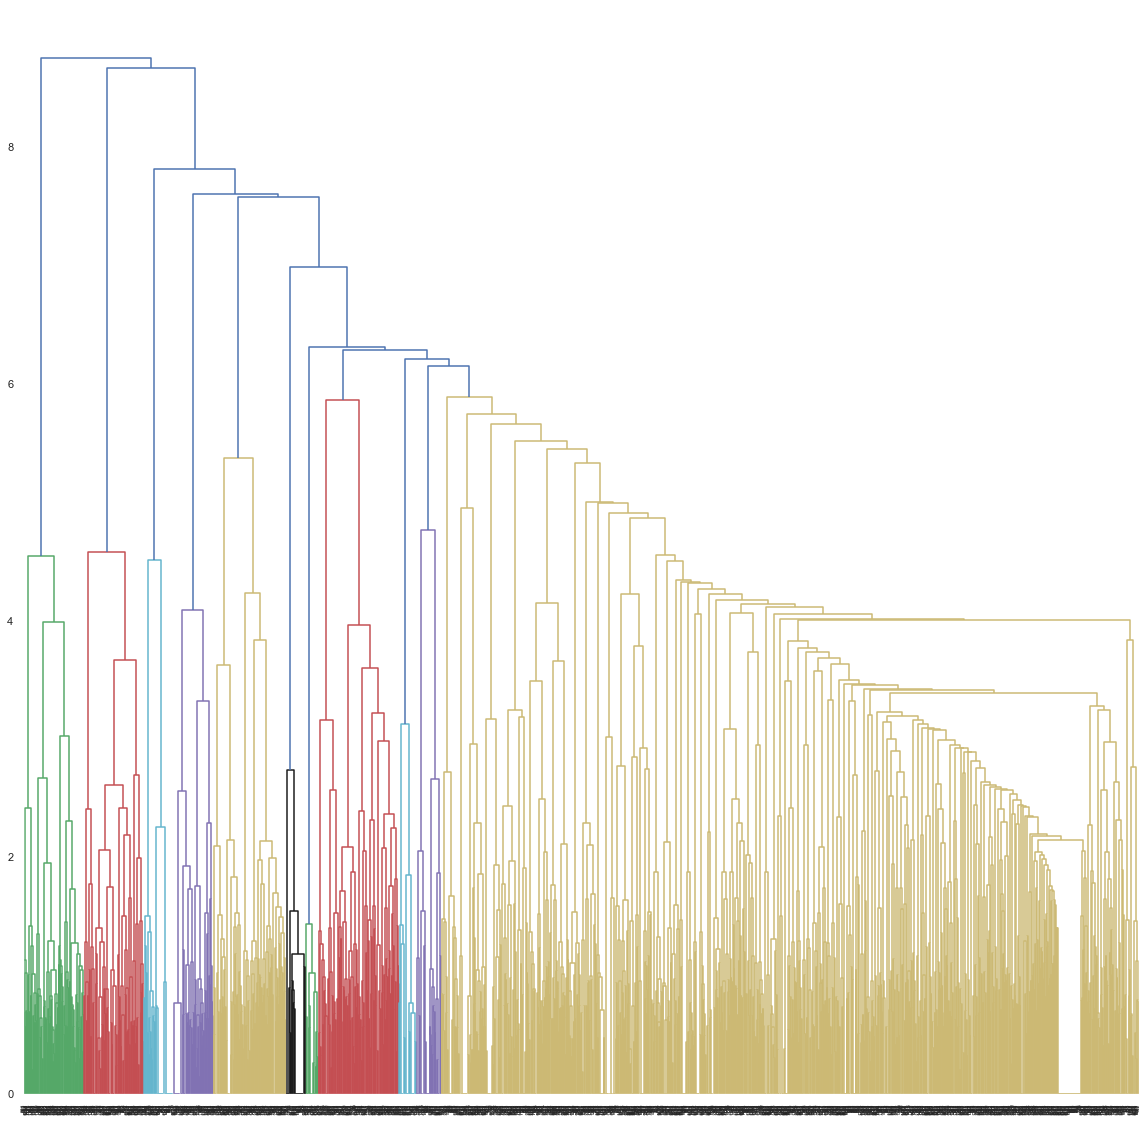

In [36]:
plt.figure(figsize=(20, 20))
plot_dendrogram(agclust)

**Kmeans**

In [37]:
kmeans_db = {}
kmeans_silh = {}
range_clusters = [3, 5, 8, 15, 20, 30, 50, 75, 100, 200]
for n_clusters in tqdm(range_clusters):
    clusterer = KMeans(n_clusters=n_clusters, n_jobs=-1, random_state=SEED)
    preds_kmeans = clusterer.fit_predict(matrix)
    #centers = clusterer.cluster_centers_

    kmeans_silh[n_clusters] = silhouette_score(matrix, preds_kmeans, metric='cosine')
    kmeans_db[n_clusters] = davies_bouldin_score(matrix, preds_kmeans)

In [38]:
print(sorted(kmeans_silh.items(), key=lambda x: x[1], reverse=True)[:2])
print(sorted(kmeans_db.items(), key=lambda x: x[1], reverse=False)[:2])

[(200, 0.3949676741853159), (100, 0.30880559644183647)]
[(200, 1.5326199053913763), (100, 1.7785661561591721)]


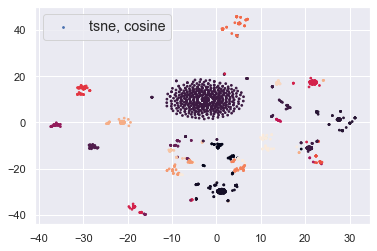

In [89]:
preds_kmeans = KMeans(n_clusters=20, n_jobs=-1, random_state=SEED).fit_predict(matrix)
plot_embeddings(matrix.copy(), 'tsne', 'cosine', c=preds_kmeans)

In [98]:
preds_kmeans[preds_kmeans==3].shape, preds_kmeans.shape

((776,), (1920,))

In [90]:
silhouette_score(matrix, preds_kmeans, metric='cosine')

0.2086934072859685

In [99]:
df['preds'] = preds_kmeans

In [100]:
df[df['preds'] == 3]

,company_categories,company_features,company_name,phone_number,cat_feats,cat_feats_name,preds
1,агентство недвижимости,,индустриальное,79028351016,агентство недвижимости,агентство недвижимости индустриальное,3
4,регистрационная палата министерства ведомства ...,,межрайонный отдел перми управления росреестра ...,73422836588,регистрационная палата министерства ведомства ...,регистрационная палата министерства ведомства ...,3
5,такси,,новое такси,73953453000,такси,такси новое такси,3
8,электротехническая продукция кабель провод све...,,электромир,73512402001,электротехническая продукция кабель провод све...,электротехническая продукция кабель провод све...,3
13,пенсионный фонд,,пенсионный фонд,73512822828,пенсионный фонд,пенсионный фонд пенсионный фонд,3
...,...,...,...,...,...,...,...
1911,интернет провайдер телефония кабельное телевид...,технология сервисы услуги интернет,игра сервис,73912913913,интернет провайдер телефония кабельное телевид...,интернет провайдер телефония кабельное телевид...,3
1912,интернет провайдер телефония кабельное телевид...,технология сервисы услуги интернет,игра сервис,73912913913,интернет провайдер телефония кабельное телевид...,интернет провайдер телефония кабельное телевид...,3
1913,интернет провайдер телефония интернет маркетин...,технология сервисы услуги интернет,игра сервис,73912913913,интернет провайдер телефония интернет маркетин...,интернет провайдер телефония интернет маркетин...,3
1914,автобусные междугородные перевозки управление ...,,пассажиртур,78313093939,автобусные междугородные перевозки управление ...,автобусные междугородные перевозки управление ...,3


**DBSCAN**

In [101]:
dbscan_silh = {}
dbscan_db = {}
for eps in tqdm([0.01, 0.05, 0.15, 0.2, 0.225, 0.25, 0.275, 0.3, 0.33, 0.37, 0.4, 0.45, 0.5]):
    for min_samples in [3, 4, 5, 6, 8, 10, 13, 15]:
        clusterer = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine', n_jobs=-1)
        preds = clusterer.fit_predict(matrix)
        dbscan_db[str(eps)+'_'+str(min_samples)] = davies_bouldin_score(matrix, preds)
        dbscan_silh[str(eps)+'_'+str(min_samples)] = silhouette_score(matrix, preds, metric='cosine')

In [102]:
print(sorted(dbscan_silh.items(), key=lambda x: x[1], reverse=True)[:2])
print(sorted(dbscan_db.items(), key=lambda x: x[1], reverse=False)[:2])

[('0.05_3', 0.4684108393477469), ('0.05_4', 0.4288077671585836)]
[('0.01_3', 0.6588563548427462), ('0.05_3', 0.6631555064901633)]


In [103]:
dbscan_db['0.33_3']

2.4381751714213076

In [109]:
#best dbscan
dbscan = DBSCAN(eps=0.03, min_samples=3, metric='cosine', n_jobs=-1)
preds_dbscan = dbscan.fit_predict(matrix)
print(f"silhouette dbscan: {silhouette_score(matrix, preds_dbscan, metric='cosine')}")

silhouette dbscan: 0.4450895933085863


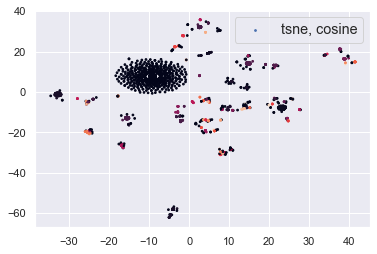

In [110]:
plot_embeddings(matrix.copy(), 'tsne', 'cosine', c=preds_dbscan)

In [111]:
np.unique(preds_dbscan).shape[0]

75

In [106]:
#check agglomerativeclustering with got number of clusters
preds_agl = AgglomerativeClustering(np.unique(preds_dbscan).shape[0]).fit_predict(matrix)

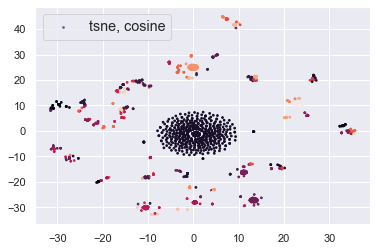

In [107]:
plot_embeddings(matrix.copy(), 'tsne', 'cosine', c=preds_agl)

In [108]:
silhouette_score(matrix, preds_agl, metric='cosine')

0.15144741509592674

**Sum up:** I think word2vec should be tried to get better results or at least we need to encode text in a better way to get clustered structure